In [8]:
import pandas
import matplotlib.pyplot as plt
import itertools
import math
import datetime
import re
import json
import tqdm
import pickle
import matplotlib.pyplot as plt

rules_list = ["\\AddRandomRequestShort",
                "\\AddSystematicRequestShort",
                "\\RemoveRandomRequestShort",
                "\\RemoveSystematicServedRequestShort",
                "\\RemoveSystematicUnservedRequestShort",
                "\\ServedCloserMaxShort",
                "\\ServedCloserMidShort",
                "\\ServedCloserMinShort",
                "\\ServedFurtherMaxShort",
                "\\ServedFurtherMidShort",
                "\\ServedFurtherMinShort",
                "\\UnservedCloserMaxShort",
                "\\UnservedCloserMidShort",
                "\\UnservedCloserMinShort",
                "\\UnservedFurtherMaxShort",
                "\\UnservedFurtherMidShort",
                "\\UnservedFurtherMinShort",
                "\\ChangeServiceTimeArgShort{-60}",
                "\\ChangeServiceTimeArgShort{-55}",
                "\\ChangeServiceTimeArgShort{-50}",
                "\\ChangeServiceTimeArgShort{-45}",
                "\\ChangeServiceTimeArgShort{-40}",
                "\\ChangeServiceTimeArgShort{-35}",
                "\\ChangeServiceTimeArgShort{-30}",
                "\\ChangeServiceTimeArgShort{-25}",
                "\\ChangeServiceTimeArgShort{-20}",
                "\\ChangeServiceTimeArgShort{-15}",
                "\\ChangeServiceTimeArgShort{-10}",
                "\ChangeServiceTime",
                "\ChangeServiceTimeArgShort{-5}",
                "\\ChangeServiceTimeArgShort{5}",
                "\\ChangeServiceTimeArgShort{10}",
                "\\ChangeServiceTimeArgShort{15}",
                "\\ChangeServiceTimeArgShort{20}",
                "\\ChangeServiceTimeArgShort{25}",
                "\\ChangeServiceTimeArgShort{30}",
                "\\ChangeServiceTimeArgShort{35}",
                "\\ChangeServiceTimeArgShort{40}",
                "\\ChangeServiceTimeArgShort{45}",
                "\\ChangeServiceTimeArgShort{50}",
                "\\ChangeServiceTimeArgShort{55}",
                "\\ChangeServiceTimeArgShort{60}",
                "\\ChangeServiceTimeArgShort{others}",
                "\ChangeUtilizationTime",
                "\ChangeUtilizationTimeArgShort{-60}",
                "\ChangeUtilizationTimeArgShort{-45}",
                "\ChangeUtilizationTimeArgShort{-30}",
                "\ChangeUtilizationTimeArgShort{-15}",
                "\ChangeUtilizationTimeArgShort{-10}",
                "\ChangeUtilizationTimeArgShort{-5}",
                "\ChangeUtilizationTimeArgShort{5}",
                "\ChangeUtilizationTimeArgShort{10}",
                "\ChangeUtilizationTimeArgShort{15}",
                "\ChangeUtilizationTimeArgShort{30}",
                "\ChangeUtilizationTimeArgShort{45}",
                "\ChangeUtilizationTimeArgShort{60}"
]

def rules_index(rule):
    try:
        return rules_list.index(rule)
    except ValueError:
        return len(rules_list)

# Loading data

In [9]:
original_df = pandas.read_csv("../experiments_logs/original_results.csv")
followup_df = pandas.read_csv("../experiments_logs/followup_results.zip")
followup_df["rule"] = "\\" + followup_df["rule"].astype(str) + "Short"
followup_df["rule"] = followup_df["rule"].str.replace(r'\\ChangeUtilizationTime(-?\d+)Short', r'\\ChangeUtilizationTimeArgShort{\1}', regex=True)
followup_df["rule"] = followup_df["rule"].str.replace(r'\\ChangeServiceTime(-?\d+)Short', r'\\ChangeServiceTimeArgShort{\1}', regex=True)

merged_df = original_df.merge(followup_df,
                              on=["seed", "num_customer_requests", "num_robots", "num_operators", "utilization_time_period"],
                              suffixes=("_original", "_followup"))

# Compute rule violations

In [10]:
def apply_rules(results_df, rules, rule_functions):
    if not rules or not rule_functions or len(rules) != len(rule_functions):
        return None
    _results_df = results_df.copy(True)
    for rule, rule_function in zip(rules, rule_functions):
        _results_df.loc[_results_df["rule"].str.contains(rule, regex=True), "followed"] = _results_df[_results_df["rule"].str.contains(rule, regex=True)].apply(rule_function, axis = 1)
    return _results_df.dropna(how="any")

original_better_num_del = lambda delta = 0: (lambda row: row["num_delivered_original"] + delta >= row["num_delivered_followup"])
original_worse_num_del = lambda delta = 0: (lambda row: row["num_delivered_original"] <= row["num_delivered_followup"] + delta)
num_del_equal = lambda delta = 0: (lambda row: row["num_delivered_original"] - delta <= row["num_delivered_followup"] <= row["num_delivered_original"] + delta)

results_df = apply_rules(merged_df,
                        ["AddRandomRequest", "AddSystematicRequest", "ChangeServiceTime[^-]*\d", "ChangeServiceTime[^-]*-", 
                        "ChangeUtilizationTime[^-]*\d", "ChangeUtilizationTime[^-]*-", "RemoveRandomRequest", 
                         "RemoveSystematicServedRequest", "RemoveSystematicUnservedRequest", "Closer", "ServedFurther", "UnservedFurther"],
                        [original_worse_num_del(), original_worse_num_del(), original_worse_num_del(), original_better_num_del(),
                         original_worse_num_del(), original_better_num_del(), original_better_num_del(),
                         original_better_num_del(), num_del_equal(), original_worse_num_del(), original_better_num_del(), num_del_equal()
                        ])

# Analyse results
## RQ1 - Analyse break rate

Followed: 3966
Broken: 4134


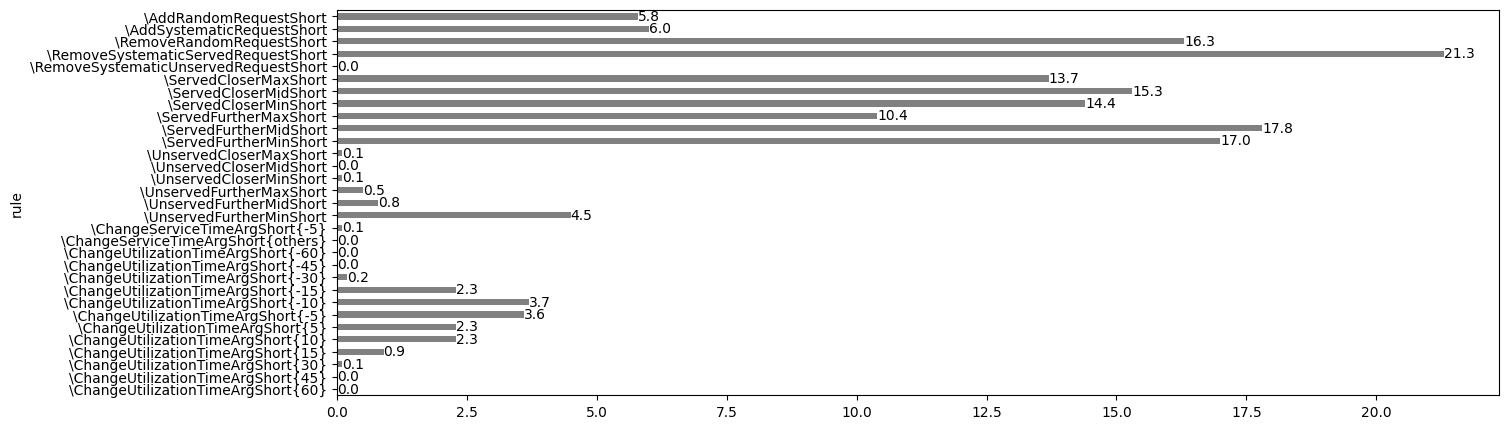

In [11]:
results_agged_by_rule = results_df.groupby(by=["rule", "seed", "num_customer_requests", "num_robots", "num_operators", "utilization_time_period"]).all()
results_agged_by_conf = results_df.groupby(by=["seed", "num_customer_requests", "num_robots", "num_operators", "utilization_time_period"]).all()
count_followed = len(results_agged_by_conf[results_agged_by_conf["followed"] == True])
count_broken = len(results_agged_by_conf[results_agged_by_conf["followed"] == False])
print("Followed:", count_followed)
print("Broken:", count_broken)

break_per_rule_df = results_agged_by_rule["followed"].groupby(by=["rule"]).value_counts()
break_per_rule_df = pandas.concat([break_per_rule_df, results_agged_by_rule["followed"].groupby(by=["rule"]).value_counts(normalize=True).mul(100).round(1)], axis = 1)
for rule in set([ x[0] for x in break_per_rule_df.index]):
    if (rule, False) not in break_per_rule_df.index:
        zero_data = {'index': [(rule, False)],
              'columns': ["count", "proportion"],
              'data': [[0, 0]],
              'index_names': ['rule', 'followed'],
              'column_names': [""]}
        zero_row = pandas.DataFrame.from_dict(zero_data, orient='tight')
        break_per_rule_df = pandas.concat([break_per_rule_df, zero_row])

df_to_plot = break_per_rule_df.loc[(slice(None),False),:].droplevel('followed')
df_to_plot.sort_index(inplace=True)
df_to_plot.rename(index = lambda x: "\\ChangeServiceTimeArgShort{others}" if "ChangeServiceTime" in x and df_to_plot.loc[x]["count"] == 0 else x, inplace=True)
df_to_plot["index_col"] = df_to_plot.index
df_to_plot.drop_duplicates(inplace=True)
df_to_plot.drop(["index_col"], axis=1, inplace=True)
df_to_plot.sort_index(inplace=True, key=lambda idx: [rules_index(x) for x in idx], ascending=False)
ax = df_to_plot.plot.barh(y="proportion", figsize=(15, 5), legend=None, color="gray")
_ = ax.bar_label(ax.containers[0], fmt='%.1f')

# RQ2 - Difference size

In [12]:
metric ="num_delivered"
results_df[metric + "_delta"] = (results_df[metric + "_followup"] - results_df[metric + "_original"]).div(results_df[metric + "_original"]) * 100
results_df[metric + "_delta_abs"] = (results_df[metric + "_followup"] - results_df[metric + "_original"])

print("Relation & -3 & -2 & -1 & 1 & 2 & 3\\\\")
for rule in sorted(results_df["rule"].unique(), key=rules_index):
    line = rule
    count_all = len(results_df[(results_df["followed"] == False) & (results_df["rule"] == rule)])
    if count_all == 0:
        continue
    for delta in [-3, -2, -1, 1, 2, 3]:
        line = line + " & " + str(round(len(results_df[(results_df["followed"] == False) & (results_df["rule"] == rule) & (results_df[metric + "_delta_abs"] == delta)]) /
                        count_all * 100, 2))
    line = line + " \\\\"
    print(line)

Relation & -3 & -2 & -1 & 1 & 2 & 3\\
\AddRandomRequestShort & 0.0 & 1.35 & 98.65 & 0.0 & 0.0 & 0.0 \\
\AddSystematicRequestShort & 0.0 & 1.49 & 98.51 & 0.0 & 0.0 & 0.0 \\
\RemoveRandomRequestShort & 0.0 & 0.0 & 0.0 & 95.03 & 4.66 & 0.31 \\
\RemoveSystematicServedRequestShort & 0.0 & 0.0 & 0.0 & 95.28 & 4.63 & 0.09 \\
\ServedCloserMaxShort & 0.0 & 1.94 & 98.06 & 0.0 & 0.0 & 0.0 \\
\ServedCloserMidShort & 0.0 & 2.98 & 97.02 & 0.0 & 0.0 & 0.0 \\
\ServedCloserMinShort & 0.11 & 1.93 & 97.96 & 0.0 & 0.0 & 0.0 \\
\ServedFurtherMaxShort & 0.0 & 0.0 & 0.0 & 97.3 & 2.7 & 0.0 \\
\ServedFurtherMidShort & 0.0 & 0.0 & 0.0 & 96.22 & 3.78 & 0.0 \\
\ServedFurtherMinShort & 0.0 & 0.0 & 0.0 & 96.97 & 3.03 & 0.0 \\
\UnservedCloserMaxShort & 0.0 & 0.0 & 100.0 & 0.0 & 0.0 & 0.0 \\
\UnservedCloserMinShort & 0.0 & 0.0 & 100.0 & 0.0 & 0.0 & 0.0 \\
\UnservedFurtherMaxShort & 0.0 & 0.0 & 0.0 & 100.0 & 0.0 & 0.0 \\
\UnservedFurtherMidShort & 0.0 & 0.0 & 0.0 & 100.0 & 0.0 & 0.0 \\
\UnservedFurtherMinShort & 0.0 &

# RQ3 - Subsumption

In [13]:
def results_to_subsumption(results_df, rules):
    rules = sorted(rules, key=rules_index)
    subsumption_df = pandas.DataFrame(columns=rules, index=rules)
    for rule_1_idx in tqdm.tqdm(range(len(rules))):
        rule_1 = rules[rule_1_idx]
        subsumption_df.loc[rule_1, rule_1] = "\\notApplicableDiag"
        followups_1 = results_df_copy[results_df_copy["rule"].str.contains(rule_1, regex=False)][["seed", "num_customer_requests", "num_robots", "num_operators", "utilization_time_period", "followed"]]
        results_1 = followups_1.groupby(by=["seed", "num_customer_requests", "num_robots", "num_operators", "utilization_time_period"]).all()
        for rule_2_idx in range(rule_1_idx + 1, len(rules)):
            rule_2 = rules[rule_2_idx]
            if rule_1 in rule_2 or rule_2 in rule_1:
                subsumption_df.loc[rule_1, rule_2] = "N/A"
                subsumption_df.loc[rule_2, rule_1] = "N/A"
                continue
            followups_2 = results_df_copy[results_df_copy["rule"].str.contains(rule_2, regex=False)][["seed", "num_customer_requests", "num_robots", "num_operators", "utilization_time_period", "followed"]]
            results_2 = followups_2.groupby(by=["seed", "num_customer_requests", "num_robots", "num_operators", "utilization_time_period"]).all()
            results_both = results_1.merge(results_2,
                                               on=["seed", "num_customer_requests", "num_robots", "num_operators", "utilization_time_period"],
                                               suffixes=("_r_1", "_r_2"))
            r_1_broken = results_both[(results_both["followed_r_1"] == False)]
            count_r_1_broken = r_1_broken.shape[0]
            count_r_2_broken = results_both[(results_both["followed_r_2"] == False)].shape[0]
            if count_r_1_broken == 0 and count_r_2_broken == 0:
                subsumption_df.loc[rule_1, rule_2] = "\\notApplicable"
                subsumption_df.loc[rule_2, rule_1] = "\\notApplicable"
                continue
            count_both_broken = r_1_broken[r_1_broken["followed_r_2"] == False].shape[0]
            if count_r_1_broken == 0:
                subsumption_df.loc[rule_1, rule_2] = "\\notApplicable"
            else:
                subsumption_df.loc[rule_1, rule_2] = round(count_both_broken / count_r_1_broken * 100, 2)

            if count_r_2_broken == 0:
                subsumption_df.loc[rule_2, rule_1] = "\\notApplicable"
            else: 
                subsumption_df.loc[rule_2, rule_1] = round(count_both_broken / count_r_2_broken * 100, 2)
    return subsumption_df

results_df_copy = results_df.copy()

rules = list(filter(lambda x: all(not char.isdigit() for char in x), results_df_copy.rule.unique()))
rules += ["\\ChangeServiceTime", "\\ChangeUtilizationTime"]
subsumption_df = results_to_subsumption(results_df, rules)

# Remove lines/columns for rules that are never broken
subsumption_df_clean = subsumption_df.copy()
nunique = subsumption_df_clean.nunique(axis=1)
rows_to_drop = nunique[nunique <= 2].index
subsumption_df_clean.drop(rows_to_drop, axis=1, inplace=True)
subsumption_df_clean.drop(rows_to_drop, inplace=True)

print(subsumption_df_clean.to_latex(float_format="%.1f"))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:43<00:00,  2.27s/it]

\begin{tabular}{llllllllllllllllll}
\toprule
 & \AddRandomRequestShort & \AddSystematicRequestShort & \RemoveRandomRequestShort & \RemoveSystematicServedRequestShort & \ServedCloserMaxShort & \ServedCloserMidShort & \ServedCloserMinShort & \ServedFurtherMaxShort & \ServedFurtherMidShort & \ServedFurtherMinShort & \UnservedCloserMaxShort & \UnservedCloserMinShort & \UnservedFurtherMaxShort & \UnservedFurtherMidShort & \UnservedFurtherMinShort & \ChangeServiceTime & \ChangeUtilizationTime \\
\midrule
\AddRandomRequestShort & \notApplicableDiag & 52.8 & 8.8 & 12.6 & 56.4 & 63.0 & 60.9 & 5.6 & 8.6 & 10.9 & 0.8 & 1.3 & 0.0 & 0.8 & 1.5 & 0.0 & 22.3 \\
\AddSystematicRequestShort & 50.8 & \notApplicableDiag & 10.5 & 14.2 & 56.8 & 61.5 & 59.9 & 5.8 & 7.8 & 10.1 & 0.5 & 0.2 & 0.0 & 0.2 & 1.2 & 0.0 & 17.8 \\
\RemoveRandomRequestShort & 3.1 & 3.9 & \notApplicableDiag & 82.4 & 6.2 & 9.8 & 8.8 & 31.7 & 48.4 & 44.9 & 0.0 & 0.0 & 0.5 & 0.8 & 9.4 & 1.0 & 17.8 \\
\RemoveSystematicServedRequestShort & 3.